Importation des librairies nécessaires

In [438]:
import pandas as pd
import os
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb 
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Chargement des données :

In [439]:
ot_odr_filename = os.path.join(".", "OT_ODR.csv.bz2")
ot_odr_df = pd.read_csv(ot_odr_filename,
                        compression="bz2",
                        sep=";")

equipements_filename = os.path.join(".", 'EQUIPEMENTS.csv')
equipements_df = pd.read_csv(equipements_filename,
                             sep=";")
                             

On regroupe les df pour récupérer les informations sur l'équipement

In [440]:
ot_odr_equip_df = pd.merge(ot_odr_df, equipements_df, on='EQU_ID', how='inner')
ot_odr_equip_df.count()

OT_ID            506558
ODR_ID           506558
ODR_LIBELLE      506558
TYPE_TRAVAIL     506558
DUREE_TRAVAIL    506558
SYSTEM_N1        506558
SYSTEM_N2        506558
SYSTEM_N3        506558
EQU_ID           506558
DATE_OT          506558
KILOMETRAGE      506557
SIG_ORGANE       506558
SIG_CONTEXTE     506558
SIG_OBS          506558
LIGNE            506558
MODELE           506558
CONSTRUCTEUR     506558
MOTEUR           506558
dtype: int64

On visualise la cardinalité de chaque champ pour soit éliminer des champs, soit réduire leur cardinalité.

In [441]:
for k in ot_odr_equip_df.keys():
    print('{0}: {1}'.format(k, len(ot_odr_equip_df[k].unique())))

OT_ID: 405957
ODR_ID: 506558
ODR_LIBELLE: 1410
TYPE_TRAVAIL: 12
DUREE_TRAVAIL: 237
SYSTEM_N1: 10
SYSTEM_N2: 45
SYSTEM_N3: 150
EQU_ID: 4819
DATE_OT: 396752
KILOMETRAGE: 385396
SIG_ORGANE: 116
SIG_CONTEXTE: 5509
SIG_OBS: 59
LIGNE: 541
MODELE: 61
CONSTRUCTEUR: 13
MOTEUR: 53


On visualise la répartition du champ 'KILOMETRAGE' :

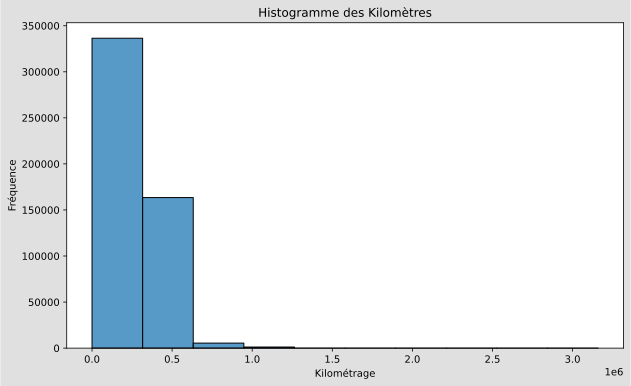

In [442]:
plt.figure(figsize=(10, 6))
sns.histplot(ot_odr_equip_df['KILOMETRAGE'], bins=10, kde=False)
plt.title('Histogramme des Kilomètres')
plt.xlabel('Kilométrage')
plt.ylabel('Fréquence')
plt.show()


On prépare une fonction pour réduire  la cardinalité du champ 'KILOMETRAGE'

In [443]:
# Définir une fonction pour attribuer des catégories
def categorize_kilometrage(km):
    if km < 50000:
        return 'C:0-50k'
    elif km < 100000:
        return 'C:50k-100k'
    elif km < 150000:
        return 'C:100k-150k'
    elif km < 200000:
        return 'C:150k-200k'
    elif km < 250000:
        return 'C:200k-250k'
    elif km < 300000:
        return 'C:250k-300k'
    elif km < 350000:
        return 'C:300k-350k'
    elif km < 400000:
        return 'C:350k-400k'
    elif km < 450000:
        return 'C:400k-450k'
    elif km < 500000:
        return 'C:450k-500k'
    else:
        return 'C:500k+'

On définit les champs manipulés :

In [444]:
var_cat = ["MODELE", "MOTEUR", "KILOMETRAGE",
            'SYSTEM_N1', 'SYSTEM_N2', 'SYSTEM_N3', 
            'SIG_ORGANE', 'SIG_CONTEXTE', 'SIG_OBS']

On prépare une fonction pour changer le type des variables catégorielles avec la méthode `.astype('category')` :

In [445]:
def apply_cat(df) :

    for var in var_cat:
        df[var] = df[var].astype('category')

In [446]:
def pretreat(df):
    """
        Clean the dataset to keep only the neccessary columns, to remove the lines containing na field and to reduce cardinality
    """
    df.dropna(inplace=True)
    df['KILOMETRAGE'] = df['KILOMETRAGE'].apply(categorize_kilometrage)
    
    droped_cols = [col for col in ["OT_ID", "ODR_ID", "EQU_ID", "ODR_LIBELLE", "TYPE_TRAVAIL", "DATE_OT", 'DUREE_TRAVAIL', "LIGNE"] if col in df.columns]
    df = df.drop(droped_cols, axis=1)
    
    apply_cat(df)
    return df

In [447]:
def read_df(path) :
    """
        Open a csv file and make it usable with pyagrum
    """

    df = pd.read_csv(path, sep=";")

    apply_cat(df)
    
    return df


In [448]:
pretreat_df = pretreat(ot_odr_equip_df)

#On affiche les catégories nouvelles créées pour le champ 'KILOMETRAGE'
pretreat_df['KILOMETRAGE'].unique()

['C:100k-150k', 'C:200k-250k', 'C:250k-300k', 'C:300k-350k', 'C:350k-400k', ..., 'C:450k-500k', 'C:500k+', 'C:50k-100k', 'C:150k-200k', 'C:0-50k']
Length: 11
Categories (11, object): ['C:0-50k', 'C:100k-150k', 'C:150k-200k', 'C:200k-250k', ..., 'C:400k-450k', 'C:450k-500k', 'C:500k+', 'C:50k-100k']

On divise le dataset en données d'entrainement et de test :

In [449]:
train_df, test_df = train_test_split(pretreat_df, test_size=0.25, random_state=42)


Pour pouvoir manipuler les données correctement avec pyAgrum, on a besoin de passer par un fichier intermédiaire pour sauvegarder les données.

In [450]:
train_filename = os.path.join(".", 'train.csv')
train_df.to_csv(train_filename, sep=';', index=False)


test_filename = os.path.join(".", 'test.csv')
test_df.to_csv(test_filename, sep=';', index=False)

In [472]:
train_df.count()

SYSTEM_N1       379917
SYSTEM_N2       379917
SYSTEM_N3       379917
KILOMETRAGE     379917
SIG_ORGANE      379917
SIG_CONTEXTE    379917
SIG_OBS         379917
MODELE          379917
CONSTRUCTEUR    379917
MOTEUR          379917
dtype: int64

In [473]:
test_df.count()

SYSTEM_N1       126640
SIG_OBS         126640
SIG_ORGANE      126640
MODELE          126640
SIG_CONTEXTE    126640
KILOMETRAGE     126640
dtype: int64

## Pre-learning

In [451]:
train_df = read_df(train_filename)

On étudie les différences de cardinalités entre le dataset d'entrainement et le dataset originel

In [452]:
for k in train_df.keys():
    print('{0}: {1} (difference : {2})'.format(k, len(train_df[k].unique()), len(pretreat_df[k].unique())-len(train_df[k].unique())))

SYSTEM_N1: 10 (difference : 0)
SYSTEM_N2: 45 (difference : 0)
SYSTEM_N3: 150 (difference : 0)
KILOMETRAGE: 11 (difference : 0)
SIG_ORGANE: 115 (difference : 1)
SIG_CONTEXTE: 4985 (difference : 524)
SIG_OBS: 59 (difference : 0)
MODELE: 61 (difference : 0)
CONSTRUCTEUR: 13 (difference : 0)
MOTEUR: 53 (difference : 0)


In [453]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379917 entries, 0 to 379916
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   SYSTEM_N1     379917 non-null  category
 1   SYSTEM_N2     379917 non-null  category
 2   SYSTEM_N3     379917 non-null  category
 3   KILOMETRAGE   379917 non-null  category
 4   SIG_ORGANE    379917 non-null  category
 5   SIG_CONTEXTE  379917 non-null  category
 6   SIG_OBS       379917 non-null  category
 7   MODELE        379917 non-null  category
 8   CONSTRUCTEUR  379917 non-null  object  
 9   MOTEUR        379917 non-null  category
dtypes: category(9), object(1)
memory usage: 7.1+ MB


In [454]:
pretreat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506557 entries, 0 to 506557
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   SYSTEM_N1     506557 non-null  category
 1   SYSTEM_N2     506557 non-null  category
 2   SYSTEM_N3     506557 non-null  category
 3   KILOMETRAGE   506557 non-null  category
 4   SIG_ORGANE    506557 non-null  category
 5   SIG_CONTEXTE  506557 non-null  category
 6   SIG_OBS       506557 non-null  category
 7   MODELE        506557 non-null  category
 8   CONSTRUCTEUR  506557 non-null  object  
 9   MOTEUR        506557 non-null  category
dtypes: category(9), object(1)
memory usage: 13.2+ MB


Analyse des modalités des variables de signalement :

In [455]:
var_sig = ["SIG_OBS", "SIG_ORGANE", "MODELE", "SIG_CONTEXTE", "KILOMETRAGE"]
train_df[var_sig].describe()

,SIG_OBS,SIG_ORGANE,MODELE,SIG_CONTEXTE,KILOMETRAGE
count,379917,379917,379917,379917,379917
unique,59,115,61,4985,11
top,NE FONCTIONNE PAS,ECLAIRAGE FEUX EXTERIEURS,MD017,ARRIERE,C:250k-300k
freq,113062,142325,96472,24046,53004


## Création d'un premier modèle

Nous proposons de créer un modèle permettant d'expliquer la variable SYSTEM_N1 à partir des variables "SIG_OBS", "SIG_ORGANE", "MODELE", "SIG_CONTEXTE", "KILOMETRAGE".

On commence par créer les variables du réseau.

In [456]:
var_to_model = ["SYSTEM_N1"] + var_sig

var_bn = {}
for var in var_to_model:
    nb_values = len(pretreat_df[var].cat.categories)
    var_bn[var] = gum.LabelizedVariable(var, var, nb_values)

On renseigne les modalités des variables pour être fidèle à celles des données.

In [457]:
for var in var_bn:
    for i, modalite in enumerate(pretreat_df[var].cat.categories):
        var_bn[var].changeLabel(i, modalite)

Ensuite, on crée le réseau bayésien et on ajoute les variables sélectionnées.

In [458]:
template = gum.BayesNet("SYSTEM N1")

for var in var_bn.values():
    template.add(var)

Pour finir, on fixe la structure.

In [459]:
template.addArc("SYSTEM_N1", "SIG_OBS")
template.addArc("SYSTEM_N1", "SIG_ORGANE")
template.addArc("SYSTEM_N1", "SIG_CONTEXTE")
template.addArc("SYSTEM_N1", "MODELE")
template.addArc("SYSTEM_N1", "KILOMETRAGE")



Nous pouvons utiliser temporairement un notebook Jupyter afin de vérifier graphiquement la structure et les LPC de notre modèle.

In [460]:
template

(pyAgrum.BayesNet<double>@0x5e000de3dba0) BN{nodes: 6, arcs: 5, domainSize: 10^11.4031, dim: 57519, mem: 449Ko 784o}

In [461]:
print(template)

BN{nodes: 6, arcs: 5, domainSize: 10^11.4031, dim: 57519, mem: 449Ko 784o}


Loi de probabilité de SIG_OBS :

In [462]:
template.cpt("SIG_OBS")

(pyAgrum.Potential<double>@0x5e0002560140) 
      ||  SIG_OBS                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
SYSTEM||A-COUPS  |ABSENT   |ALLUME   |ARRACHE  |ASPIRER  |BALANCE  |BLESSE   |BLOQUE   |BROUTE   |BRUTAL   |BRUYANT  |CALE     |CASSE    |CLAQUE   |CLIGNOTE |CREVE    |DEBOITE  |DECLENCHE|DEGONFLE |DELOCALIS|DEREGLE  |DESSERRE |DUR      |ENFONCE  |FAUX CONT|FENDU    |FERME MAL|FONCTIONN|FUITE    |FUME/CHAU|INCOMPLET|INSUFFISA|INTERMITT|INTERRUPT|JEU      |LACERE   |MANQUE   |MAUVAIS  |N'EMET PA|N'ENCRE P|NE FONCTI|NE TIRE P|ODEUR    |OUVRE MAL|PATINE   |RAYE     |REFUSE TI|SALE     |SECOUSSE |TAGUE    |TANGUE   |TEMOIN OU|TIRE A DR|TIRE A GA|TORDU    |USE/VIDE |VIBRE    |VOYANT AL|VOYANT HS|
------||---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
DIVERS|| 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
EQUIPE|| 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
EQUIPE|| 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |
EQUIPE|| 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0

Loi de probabilité de SYSTEM_N1 | SIG_OBS :

In [463]:
template.cpt("SYSTEM_N1")

(pyAgrum.Potential<double>@0x5e000b1c7bb0) 
  SYSTEM_N1                                                                                        |
DIVERS   |EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  |

On remarque naturellement que les LPC ne contiennent pour l'instant que des zéros…

## Apprentissage des LPC

Pour apprendre les paramètres des LPC à partir des données, vous pouvez utiliser la classe gum.BNLearner et en particulier la méthode fitParameters:

In [464]:
learner = gum.BNLearner(train_df, template)
learner.fitParameters(template)

(pyAgrum.BNLearner<double>@0x5dfff0414340) Filename       : /tmp/tmpqu0kc55_.csv
Size           : (379917,6)
Variables      : SYSTEM_N1[10], SIG_OBS[59], SIG_ORGANE[116], MODELE[61], SIG_CONTEXTE[5509], KILOMETRAGE[11]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -

Après apprentissage, nous obtenons les LPC suivantes. Loi de probabilité de SIG_OBS :

In [465]:
template.cpt("SIG_OBS")

(pyAgrum.Potential<double>@0x5e0002560140) 
      ||  SIG_OBS                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
SYSTEM||A-COUPS  |ABSENT   |ALLUME   |ARRACHE  |ASPIRER  |BALANCE  |BLESSE   |BLOQUE   |BROUTE   |BRUTAL   |BRUYANT  |CALE     |CASSE    |CLAQUE   |CLIGNOTE |CREVE    |DEBOITE  |DECLENCHE|DEGONFLE |DELOCALIS|DEREGLE  |DESSERRE |DUR      |ENFONCE  |FAUX CONT|FENDU    |FERME MAL|FONCTIONN|FUITE    |FUME/CHAU|INCOMPLET|INSUFFISA|INTERMITT|INTERRUPT|JEU      |LACERE   |MANQUE   |MAUVAIS  |N'EMET PA|N'ENCRE P|NE FONCTI|NE TIRE P|ODEUR    |OUVRE MAL|PATINE   |RAYE     |REFUSE TI|SALE     |SECOUSSE |TAGUE    |TANGUE   |TEMOIN OU|TIRE A DR|TIRE A GA|TORDU    |USE/VIDE |VIBRE    |VOYANT AL|VOYANT HS|
------||---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
DIVERS|| 0.0294  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0294  | 0.0000  | 0.0000  | 0.2647  | 0.0000  | 0.0294  | 0.0294  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.2353  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.1471  | 0.0000  | 0.0294  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0000  | 0.0882  | 0.0000  | 0.0000  | 0.0000  | 0.0294  | 0.0882  | 0.0000  |
EQUIPE|| 0.0384  | 0.0028  | 0.0001  | 0.0065  | 0.0000  | 0.0351  | 0.0117  | 0.0776  | 0.0000  | 0.0000  | 0.1436  | 0.0005  | 0.0477  | 0.0589  | 0.0080  | 0.0132  | 0.0124  | 0.0000  | 0.1281  | 0.0000  | 0.0018  | 0.0052  | 0.0659  | 0.0115  | 0.0001  | 0.0001  | 0.0004  | 0.0808  | 0.0663  | 0.0049  | 0.0003  | 0.0012  | 0.0084  | 0.0013  | 0.0003  | 0.0039  | 0.0039  | 0.0000  | 0.0000  | 0.0000  | 0.0724  | 0.0007  | 0.0021  | 0.0001  | 0.0005  | 0.0089  | 0.0000  | 0.0000  | 0.0000  | 0.0020  | 0.0003  | 0.0004  | 0.0039  | 0.0017  | 0.0002  | 0.0078  | 0.0117  | 0.0448  | 0.0018  |
EQUIPE|| 0.0008  | 0.1332  | 0.0000  | 0.0002  | 0.0000  | 0.0002  | 0.0000  | 0.0378  | 0.0000  | 0.0000  | 0.0428  | 0.0001  | 0.0674  | 0.0005  | 0.0012  | 0.0001  | 0.0052  | 0.0000  | 0.0005  | 0.0000  | 0.0000  | 0.0004  | 0.0005  | 0.0012  | 0.0000  | 0.0000  | 0.0001  | 0.1189  | 0.0983  | 0.0150  | 0.0001  | 0.1366  | 0.0049  | 0.0195  | 0.0000  | 0.0002  | 0.0101  | 0.0000  | 0.0000  | 0.0000  | 0.2417  | 0.0003  | 0.0185  | 0.0000  | 0.0000  | 0.0009  | 0.0000  | 0.0006  | 0.0000  | 0.0000  | 0.0000  | 0.0002  | 0.0001  | 0.0001  | 0.0000  | 0.0000  | 0.0003  | 0.0407  | 0.0013  |
EQUIPE|| 0.0009  | 0.0283  | 0.0000  | 0.0247  | 0.0003  | 0.0013  | 0.0001  | 0.0597  | 0.0000  | 0.0002  | 0.0113  | 0.0001  | 0.3585  | 0.0104  | 0.0018  | 0.0001  | 0.0679  | 0.0000  | 0.0018  | 0.0000  | 0.0007  | 0.0227  | 0.0023  | 0.0507  | 0.0001  | 0.0008  | 0.0034  | 0.1062  | 0.0309  | 0.0008  | 0.0011  | 0.0093  | 0.0026  | 0.0137  | 0.0000  | 0.0

Loi de probabilité de SYSTEM_N1 | SIG_OBS :

In [466]:
template.cpt("SYSTEM_N1")

(pyAgrum.Potential<double>@0x5e000b1c7bb0) 
  SYSTEM_N1                                                                                        |
DIVERS   |EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|EQUIPEMEN|
---------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
 0.0001  | 0.0314  | 0.0269  | 0.2469  | 0.0231  | 0.0449  | 0.0028  | 0.5641  | 0.0403  | 0.0196  |

## Prédictions

On prépare les données d'entrainement :

In [467]:
test_df = read_df(test_filename)
test_df = test_df[var_to_model] #On ne sélectionne que les colonnes prises pour le réseau bayésien

test_df

,SYSTEM_N1,SIG_OBS,SIG_ORGANE,MODELE,SIG_CONTEXTE,KILOMETRAGE
0,EQUIPEMENT DE CARROSSERIE,FUITE,AIR,MD051,PORTE/AVANT,C:350k-400k
1,EQUIPEMENT ELECTRIQUE,FONCTIONNE MAL,PORTE,MD017,AVANT/A LA FERMETURE,C:250k-300k
2,EQUIPEMENT DE CARROSSERIE,DESSERRE,PANNEAU,MD062,ARRIERE/DROIT/INTERIEUR,C:50k-100k
3,EQUIPEMENT ELECTRIQUE,NE FONCTIONNE PAS,ECLAIRAGE FEUX EXTERIEURS,MD041,AU FREINAGE/ARRIERE,C:150k-200k
4,EQUIPEMENT CHASSIS,CLAQUE,SUSPENSION,MD051,AVANT,C:250k-300k
...,...,...,...,...,...,...
126635,EQUIPEMENT ELECTRIQUE,MANQUE,CLIGNOTANTS/ DETRESSE,MD051,DROIT/AVANT,C:300k-350k
126636,EQUIPEMENT DE TRANSMISSION,FONCTIONNE MAL,SELECTEUR VITESSES,MD012,AU POINT MORT,C:300k-350k
126637,EQUIPEMENT ELECTRIQUE,ABSENT,ECLAIRAGE FEUX EXTERIEURS,MD065,DROIT/AVANT,C:100k-150k
126638,EQUIPEMENT DE CARROSSERIE,RAYE,PANNEAU,MD012,ARRIERE/HAUT/DROIT,C:50k-100k


À ce stade, vous pouvez reprendre la fonction predict que nous avons utilisée dans ce TD pour réaliser des prédictions d'une variable cible à partir de données. Chaque ligne des données fournies est utilisée comme évidence (conditionnement) pour calculer la loi de la variable cible sachant les données observées.

In [468]:
def predict(bn, data, var_target, show_progress=False):
    """
    This function is used to predict the posterior probability of a target variable from observations  
    using a bayesian network model. 

    Inputs:
    - =bn=: the predictive model given as a =pyAgrum.BayesNet= object
    - =data=: the data containing the observations used to predict the target variable 
    as a =pandas.DataFrame= object
    - =var_target=: the name of the target variable as a =str= object

    Returns:
    - a =DataFrame= containing the posterior probability distribution of the target 
    variable given each observation in =data=.
    """
    # Initialize the inference engine
    inf_bn = gum.LazyPropagation(bn)
    inf_bn.setTargets({var_target})
    nb_data = len(data)
    target_size = bn.variable(var_target).domainSize()
    target_dom = np.array([bn.variable(var_target).label(i)
                           for i in range(target_size)])
    data_records = data.to_dict("records")
    post_prob = np.zeros((nb_data, target_size))


    for i in range(nb_data):

        try:

            # Set the evidence
            inf_bn.setEvidence(data_records[i])
            # Run inference
            inf_bn.makeInference()
            # Compute posterior probability of target variable
            post_prob[i, :] = inf_bn.posterior(var_target).toarray()
            # Erase evidence
            inf_bn.eraseAllEvidence()
            if show_progress:
                sys.stdout.write("predict progress: {0:3.0%}\r".format(i/nb_data))

            
        except :
            print(f"Incompatible evidence in row {i}")
            continue

    post_prob_df = pd.DataFrame(post_prob,
                                index=data.index,
                                columns=bn.variable(var_target).labels())
    post_prob_df.columns.name = var_target
    return post_prob_df

In [469]:
pred_prob = predict(template,
                    data=test_df[["SIG_OBS", "SIG_ORGANE", "MODELE", "SIG_CONTEXTE", "KILOMETRAGE"]].iloc[-1000:], 
                    var_target="SYSTEM_N1",
                    show_progress=True)

pred_var = pred_prob.idxmax(axis=1).rename("pred")

Incompatible evidence in row 357
Incompatible evidence in row 568
Incompatible evidence in row 676
Incompatible evidence in row 828
Incompatible evidence in row 842


On finit par évaluer le taux de prédictions du modèle par rapport aux données observées.

In [470]:
(test_df["SYSTEM_N1"].iloc[-1000:] == pred_var).mean()

0.863

Et la matrice de confusion associée :

In [471]:
pd.crosstab(test_df["SYSTEM_N1"].iloc[-1000:], pred_var)

pred,DIVERS,EQUIPEMENT CHASSIS,EQUIPEMENT CLIMATIQUE,EQUIPEMENT DE CARROSSERIE,EQUIPEMENT DE FREINAGE,EQUIPEMENT DE MOTORISATION,EQUIPEMENT DE TRANSMISSION,EQUIPEMENT ELECTRIQUE,EQUIPEMENT EMBARQUE,EQUIPEMENT PNEUMATIQUE
SYSTEM_N1,,,,,,,,,,
EQUIPEMENT CHASSIS,0,27,0,1,1,2,0,2,0,2
EQUIPEMENT CLIMATIQUE,0,0,15,1,0,3,0,1,0,0
EQUIPEMENT DE CARROSSERIE,1,2,0,228,1,2,1,7,1,2
EQUIPEMENT DE FREINAGE,2,1,0,2,9,6,0,0,0,3
EQUIPEMENT DE MOTORISATION,0,1,1,0,2,37,2,1,0,3
EQUIPEMENT DE TRANSMISSION,0,0,0,0,0,0,3,0,0,0
EQUIPEMENT ELECTRIQUE,2,1,2,37,2,20,1,483,1,0
EQUIPEMENT EMBARQUE,0,0,0,0,0,0,0,1,49,0
EQUIPEMENT PNEUMATIQUE,0,1,0,5,2,6,1,1,0,12
